In [1]:
import pandas as pd
import scipy
import numpy as np

import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import itertools
import warnings


plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

from tqdm import tqdm

In [3]:
def get_data(start_date='20170901'):
    
    source = "https://coinmarketcap.com/currencies/bitcoin/historical-data/?start={0}&end=".format(start_date)
    bitcoin_market_info = pd.read_html(source + time.strftime("%Y%m%d"))[0]
    bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
    bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
    return bitcoin_market_info[['Date', 'Close']]

In [4]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
        plt.show()
    return

In [5]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [6]:
data = get_data()

Критерий Дики-Фуллера: p=0.418057


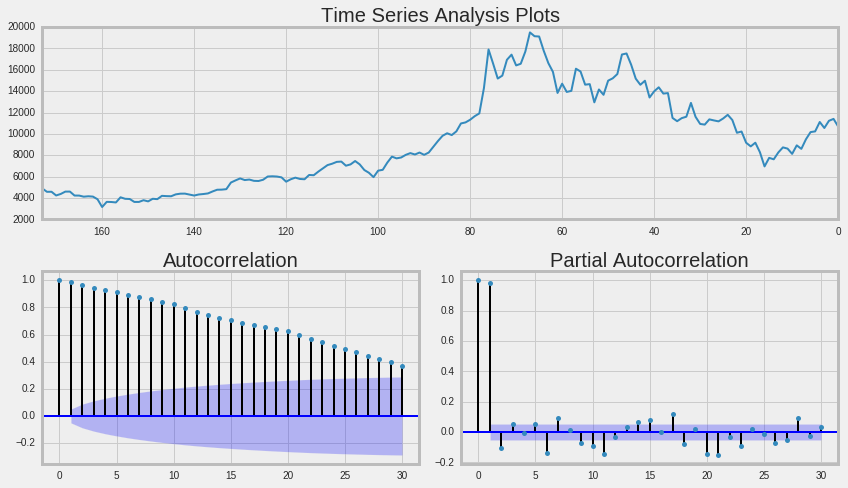

In [7]:
tsplot(data.Close[::-1], lags=30)

Критерий Дики-Фуллера: p=0.865462


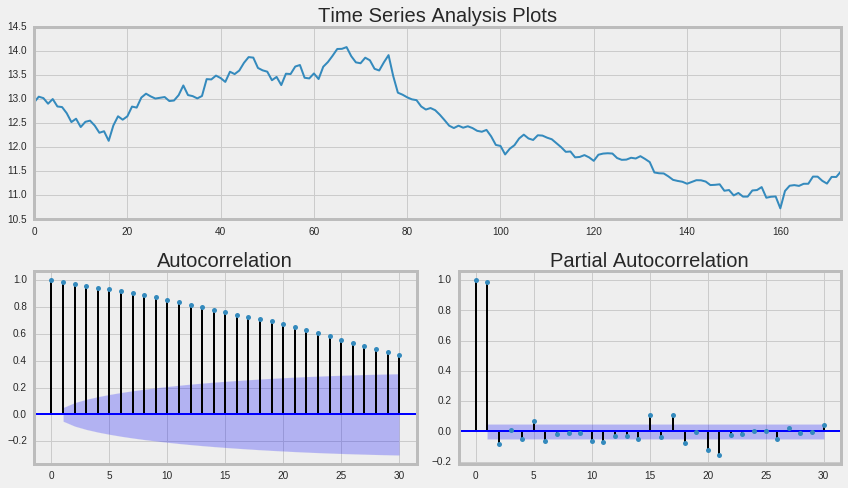

Оптимальный параметр преобразования Бокса-Кокса: 0.068008


In [8]:
data_copy = data.copy()
data_copy['Close_box_cox'], lmbda = scs.boxcox(data_copy.Close)
tsplot(data_copy.Close_box_cox, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.652691


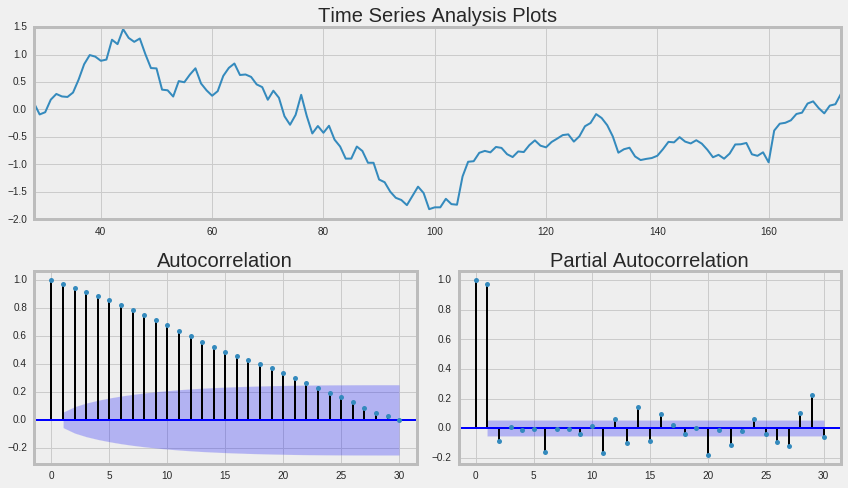

In [10]:
data_copy['close_box_week'] = data_copy.Close_box_cox - data_copy.Close_box_cox.shift(4 * 7)
tsplot(data_copy.close_box_week[4 * 7:], lags=30)

Критерий Дики-Фуллера: p=0.000000


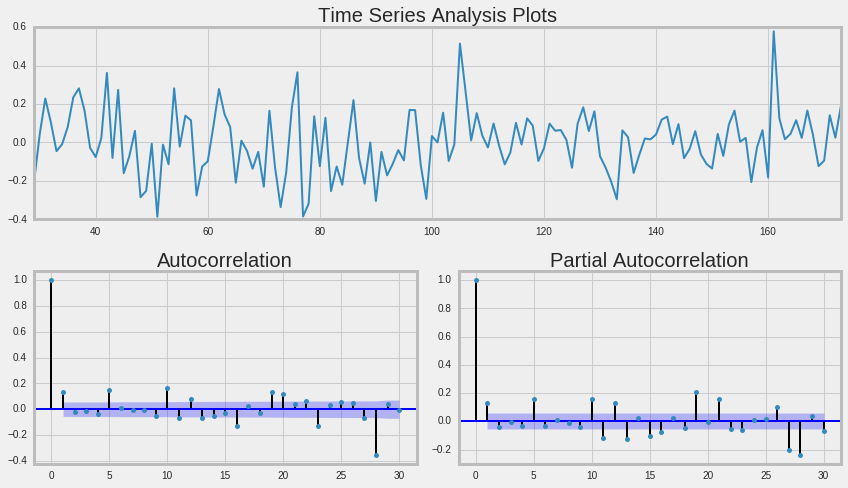

In [11]:
data_copy['close_box_diff'] = data_copy.close_box_week - data_copy.close_box_week.shift(1)
tsplot(data_copy.close_box_diff[4 * 7 + 1:], lags=30)

In [13]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [14]:
new = pd.DataFrame({'price' : data_copy['Close_box_cox'].values}, index = data.Date.values[::-1])
new.head()

,price
2017-09-01,12.929861
2017-09-02,13.051517
2017-09-03,13.021770
2017-09-04,12.905347
2017-09-05,13.002767


In [18]:
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(new.price, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 4 * 7)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())


  0%|          | 0/100 [00:00<?, ?it/s]

wrong parameters: (0, 0, 0, 0)



 30%|███       | 30/100 [18:50<1:56:30, 99.86s/it]

wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 2, 0)
wrong parameters: (1, 2, 3, 0)
wrong parameters: (1, 2, 4, 0)


 37%|███▋      | 37/100 [19:06<55:44, 53.08s/it]  /usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 39%|███▉      | 39/100 [21:37<1:09:19, 68.19s/it]/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 50%|█████     | 50/100 [36:46<1:26:42, 104.05s/it]

wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 2, 0)
wrong parameters: (2, 2, 3, 0)
wrong parameters: (2, 2, 4, 0)


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 59%|█████▉    | 59/100 [39:55<51:40, 75.63s/it]   /usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 69%|██████▉   | 69/100 [52:02<30:53, 59.78s/it]   /usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 70%|███████   | 70/100 [56:20<59:37, 119.23s/it]

wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 2, 0)
wrong parameters: (3, 2, 3, 0)
wrong parameters: (3, 2, 4, 0)


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 76%|███████▌  | 76/100 [56:25<33:30, 83.75s/it] /usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 77%|███████▋  | 77/100 [56:43<24:30, 63.95s/it]/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 78%|███████▊  | 78/100 [57:27<21:13, 57.90s/it]/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 79%|███████▉  | 79/100 [59:41<28:13, 80.64

wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 2, 0)
wrong parameters: (4, 2, 3, 0)
wrong parameters: (4, 2, 4, 0)


/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 96%|█████████▌| 96/100 [1:17:24<06:06, 91.72s/it] /usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 97%|█████████▋| 97/100 [1:17:51<03:37, 72.39s/it]/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 98%|█████████▊| 98/100 [1:18:48<02:15, 67.63s/it]/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 99%|█████████▉| 99/100 [1:21:22<01:3

      parameters         aic
3   (0, 0, 4, 0) -143.561948
8   (0, 1, 4, 0) -143.416669
23  (1, 0, 4, 0) -143.319904
7   (0, 1, 3, 0) -142.804203
22  (1, 0, 3, 0) -142.757531


/usr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-02-22 13:24:10.161357. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [19]:
best_model = sm.tsa.statespace.SARIMAX(new.price, order=(0, d, 0), 
                                        seasonal_order=(4, D, 0, 4 * 7)).fit(disp=-1)
print(best_model.summary()) 

                                 Statespace Model Results                                 
Dep. Variable:                              price   No. Observations:                  174
Model:             SARIMAX(0, 1, 0)x(4, 1, 0, 28)   Log Likelihood                  76.781
Date:                            Thu, 22 Feb 2018   AIC                           -143.562
Time:                                    15:29:44   BIC                           -127.767
Sample:                                09-01-2017   HQIC                          -137.154
                                     - 02-21-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L28      -0.7757      0.127     -6.085      0.000      -1.026      -0.526
ar.S.L56      -0.5795      0.156   

/usr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-02-22 15:27:57.647917. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Критерий Дики-Фуллера: p=0.000000


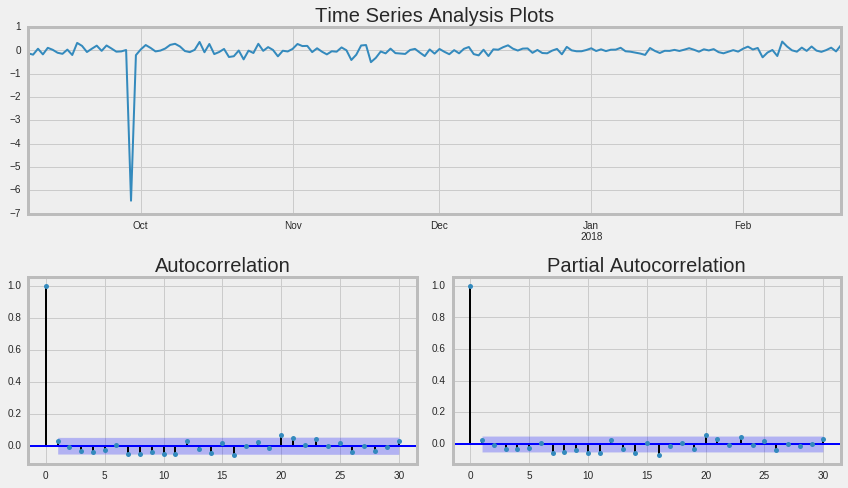

/usr/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-02-22 15:31:37.493712. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [20]:
tsplot(best_model.resid[7:], lags=30)